In [1]:
# Executing this cell will disable all TQDM outputs in stdout.
import os

os.environ["DISABLE_TQDM"] = "True"

# Computing multiple spectrograms with the Public API [^download]

[^download]: This notebook can be downloaded as **{nb-download}`example_multiple_spectrograms_public.ipynb`**.

As always in the **Public API**, the first step is to **build the dataset**.

An `Instrument` can be provided to the `Dataset` for the WAV data to be converted in pressure units. This will lead the resulting spectra to be expressed in dB SPL (rather than in dB FS):

In [2]:
from pathlib import Path

audio_folder = Path(r"_static/sample_audio")

from osekit.public_api.dataset import Dataset
from osekit.core_api.instrument import Instrument

dataset = Dataset(
    folder=audio_folder,
    strptime_format="%y%m%d_%H%M%S",
    instrument=Instrument(end_to_end_db=150.0),
)

dataset.build()

	2025-08-27 10:39:09,727
Building the dataset...



	2025-08-27 10:39:09,728
Analyzing original audio files...



	2025-08-27 10:39:09,735
Organizing dataset folder...



	2025-08-27 10:39:09,737
Build done!



The **Public API** `Dataset` is now analyzed and organized:

In [3]:
print(f"{' DATASET ':#^60}")
print(f"{'Begin:':<30}{str(dataset.origin_dataset.begin):>30}")
print(f"{'End:':<30}{str(dataset.origin_dataset.end):>30}")
print(f"{'Sample rate:':<30}{str(dataset.origin_dataset.sample_rate):>30}\n")

print(f"{' ORIGINAL FILES ':#^60}")
import pandas as pd

pd.DataFrame(
    [
        {
            "Name": f.path.name,
            "Begin": f.begin,
            "End": f.end,
            "Sample Rate": f.sample_rate,
        }
        for f in dataset.origin_files
    ],
).set_index("Name")

######################### DATASET ##########################
Begin:                                   2022-09-25 22:34:50
End:                                     2022-09-25 22:36:50
Sample rate:                                           48000

###################### ORIGINAL FILES ######################


Begin                 End  Sample Rate
Name                                                                         
sample_220925_223450.wav 2022-09-25 22:34:50 2022-09-25 22:35:00        48000
sample_220925_223500.wav 2022-09-25 22:35:00 2022-09-25 22:35:10        48000
sample_220925_223510.wav 2022-09-25 22:35:10 2022-09-25 22:35:20        48000
sample_220925_223520.wav 2022-09-25 22:35:20 2022-09-25 22:35:30        48000
sample_220925_223530.wav 2022-09-25 22:35:30 2022-09-25 22:35:40        48000
sample_220925_223600.wav 2022-09-25 22:36:00 2022-09-25 22:36:10        48000
sample_220925_223610.wav 2022-09-25 22:36:10 2022-09-25 22:36:20        48000
sample_220925_223620.wav 2022-09-25 22:36:20 2022-09-25 22:36:30        48000
sample_220925_223630.wav 2022-09-25 22:36:30 2022-09-25 22:36:40        48000
sample_220925_223640.wav 2022-09-25 22:36:40 2022-09-25 22:36:50        48000

Since we will run a spectral analysis, we need to define the FFT parameters:

In [4]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming

sample_rate = 24_000

sft = ShortTimeFFT(win=hamming(1024), hop=128, fs=sample_rate)

To **run analyses** in the **Public API**, use the `Analysis` class:

In [5]:
from osekit.public_api.analysis import Analysis, AnalysisType
from pandas import Timestamp, Timedelta

analysis = Analysis(
    analysis_type=AnalysisType.MATRIX
    | AnalysisType.SPECTROGRAM
    | AnalysisType.WELCH,  # we want to export these three spectrum outputs
    begin=Timestamp("2022-09-25 22:35:15"),
    end=Timestamp("2022-09-25 22:36:25"),
    data_duration=Timedelta(seconds=5),
    sample_rate=sample_rate,
    fft=sft,
    v_lim=(0.0, 150.0),  # Boundaries of the spectrograms
    colormap="viridis",  # Default value
    name="all_spectral_output",
)

The **Core API** can still be used on top of the **Public API**.

We will filter out the empty data this way:

In [6]:
# Returns a Core API AudioDataset that matches the analysis
audio_dataset = dataset.get_analysis_audiodataset(analysis=analysis)

# Filter the returned AudioDataset
audio_dataset.data = [ad for ad in audio_dataset.data if not ad.is_empty]

	2025-08-27 10:39:09,765
Creating the audio data...



We can also glance at the spectrogram results with the **Core API**:

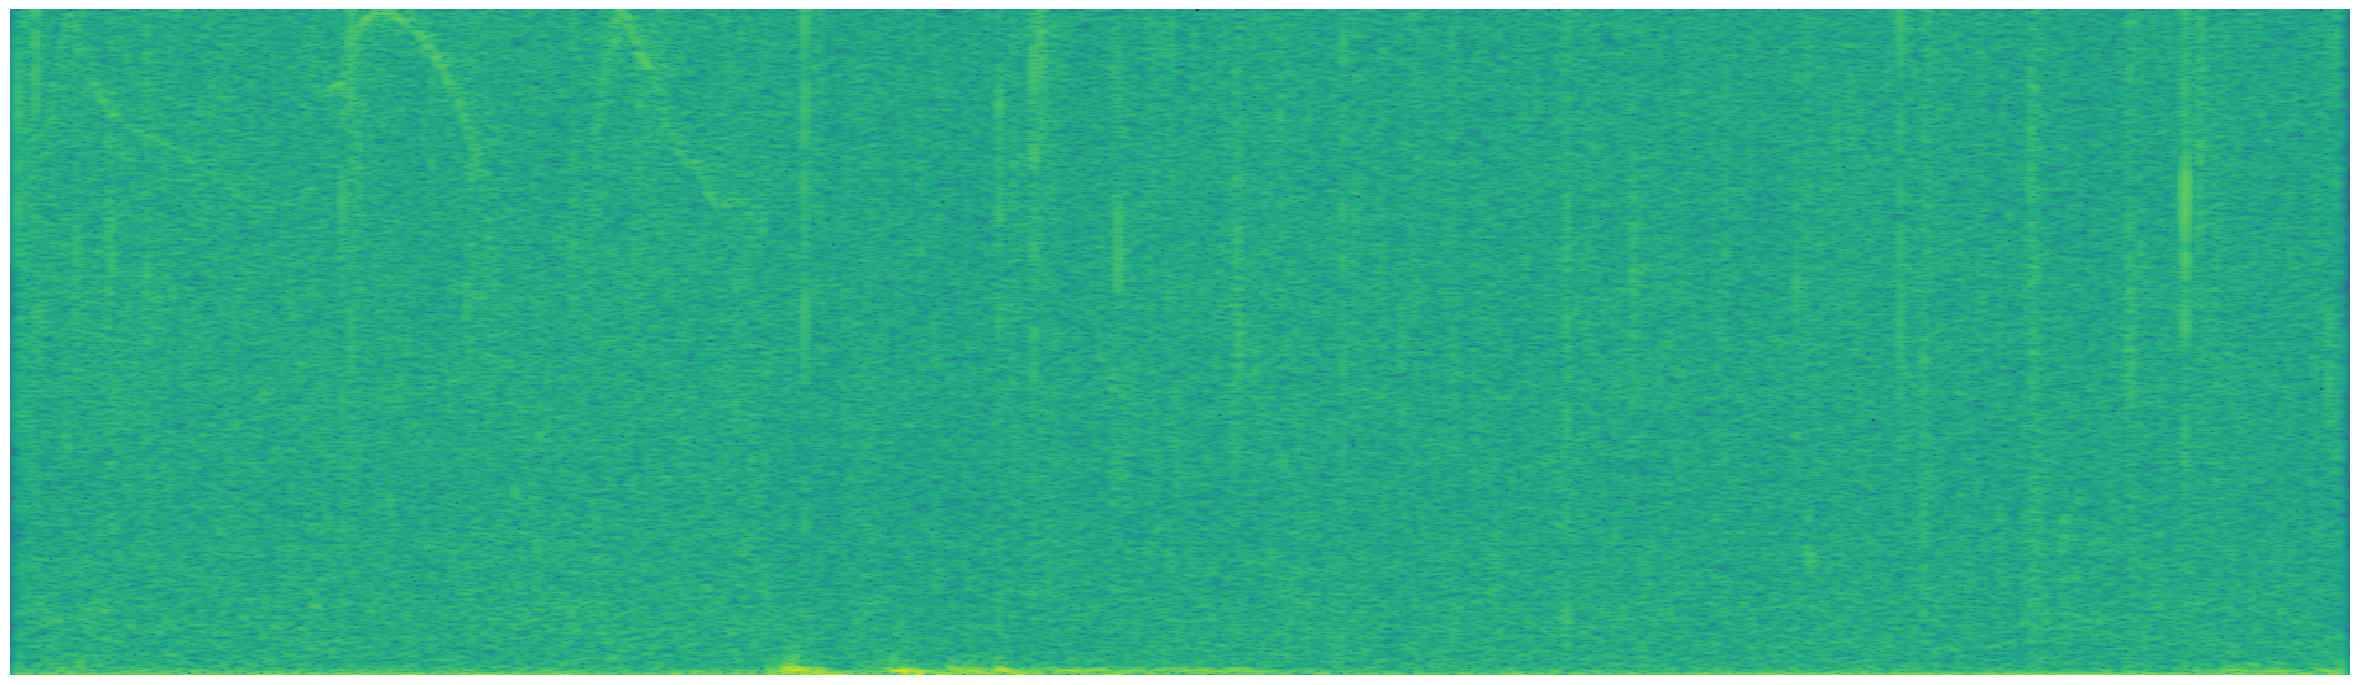

In [7]:
import matplotlib.pyplot as plt

analysis_spectro_dataset = dataset.get_analysis_spectrodataset(
    analysis=analysis,
    audio_dataset=audio_dataset,  # So that the filtered SpectroDataset is returned
)

analysis_spectro_dataset.data[1].plot()
plt.show()

Running the analysis while specifying the filtered ``audio_dataset`` will skip the empty `AudioData` (and thus the empty `SpectroData`).

In [8]:
dataset.run_analysis(analysis=analysis, audio_dataset=audio_dataset)

	2025-08-27 10:39:10,272
Running analysis...



	2025-08-27 10:39:10,273
Computing and writing spectrum matrices and spectrograms...



	2025-08-27 10:39:16,464
Computing and writing welches...



	2025-08-27 10:39:16,545
Analysis done!



All the new files from the analysis are stored in a `SpectroDataset` named after `analysis.name`:

In [9]:
pd.DataFrame(
    [
        {
            "Exported file": list(sd.files)[0].path.name,
            "Begin": sd.begin,
            "End": sd.end,
            "Sample Rate": sd.fft.fs,
        }
        for sd in dataset.get_dataset(analysis.name).data
    ],
).set_index("Exported file")

Begin                 End  \
Exported file                                                            
2022_09_25_22_35_15_000000.npz 2022-09-25 22:35:15 2022-09-25 22:35:20   
2022_09_25_22_35_20_000000.npz 2022-09-25 22:35:20 2022-09-25 22:35:25   
2022_09_25_22_35_25_000000.npz 2022-09-25 22:35:25 2022-09-25 22:35:30   
2022_09_25_22_35_30_000000.npz 2022-09-25 22:35:30 2022-09-25 22:35:35   
2022_09_25_22_35_35_000000.npz 2022-09-25 22:35:35 2022-09-25 22:35:40   
2022_09_25_22_36_00_000000.npz 2022-09-25 22:36:00 2022-09-25 22:36:05   
2022_09_25_22_36_05_000000.npz 2022-09-25 22:36:05 2022-09-25 22:36:10   
2022_09_25_22_36_10_000000.npz 2022-09-25 22:36:10 2022-09-25 22:36:15   
2022_09_25_22_36_15_000000.npz 2022-09-25 22:36:15 2022-09-25 22:36:20   
2022_09_25_22_36_20_000000.npz 2022-09-25 22:36:20 2022-09-25 22:36:25   

                                Sample Rate  
Exported file                                
2022_09_25_22_35_15_000000.npz        24000  
2022_09_25_22_35_20_000000.npz        24000  
2022_09_25_22_35_25_000000.npz        24000  
2022_09_25_22_35_30_000000.npz        24000  
2022_09_25_22_35_35_000000.npz        24000  
2022_09_25_22_36_00_000000.npz        24000  
2022_09_25_22_36_05_000000.npz        24000  
2022_09_25_22_36_10_000000.npz        24000  
2022_09_25_22_36_15_000000.npz        24000  
2022_09_25_22_36_20_000000.npz        24000

In [10]:
# Reset the dataset to get all files back to place.

dataset.reset()